### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple
# import time

%matplotlib inline

# seed = int(time.time())
# np.random.seed(seed)

### Read and Preprocess Data

In [4]:
raw_dataframe = pd.read_excel("energy+efficiency/ENB2012_data.xlsx")

print(raw_dataframe.head())
print('Mean of the raw_dataframe:')
print(raw_dataframe.mean())
print('Standard deviation of the raw_dataframe:')
print(raw_dataframe.std())

# Normalizing the data

# dataframe = raw_dataframe.copy()
dataframe = (raw_dataframe - raw_dataframe.mean()) / raw_dataframe.std()

print(dataframe.head())

X = dataframe.iloc[:, :-2]
Y = dataframe.iloc[:, -2:]

print(X.head())
print(Y.head())

     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
Mean of the raw_dataframe:
X1      0.764167
X2    671.708333
X3    318.500000
X4    176.604167
X5      5.250000
X6      3.500000
X7      0.234375
X8      2.812500
Y1     22.307195
Y2     24.587760
dtype: float64
Standard deviation of the raw_dataframe:
X1     0.105777
X2    88.086116
X3    43.626481
X4    45.165950
X5     1.751140
X6     1.118763
X7     0.133221
X8     1.550960
Y1    10.090204
Y2     9.513306
dtype: float64
         X1        X2        X3        X4        X5        X6      X7  \
0  2.040447 -1.784712 -0.561586 -1.469119  0.999349 -1.340767 -1.7593   
1  2.040447 -1.784712 -0.561586 -1.469119  0.999349 -0

### Data Visualization

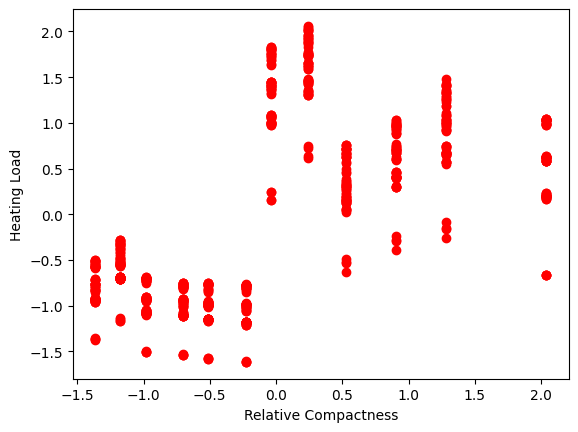

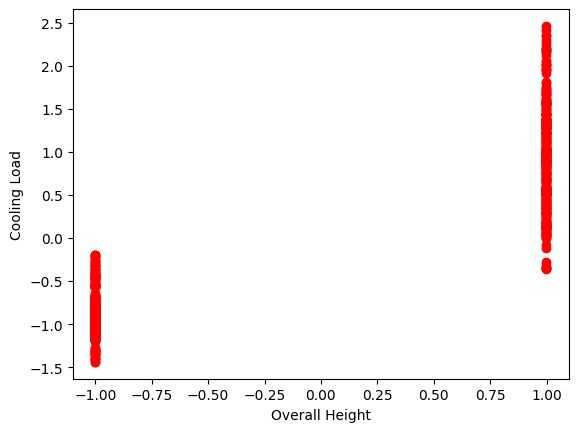

In [5]:
plt.plot(dataframe['X1'], dataframe['Y1'], 'ro')
plt.xlabel('Relative Compactness')
plt.ylabel('Heating Load')
plt.show()

plt.plot(dataframe['X5'], dataframe['Y2'], 'ro')
plt.xlabel('Overall Height')
plt.ylabel('Cooling Load')
plt.show()

### Kernels

In [6]:
def kernel(
    sigma: float,
    bandwidth: float,
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    """ Here we define the kernel function. We use the squared exponential kernel. The kernel function is used to calculate the covariance matrix.

    Args:
        sigma (float) : The standard deviation of the Gaussian distribution.
        bandwidth (float) : The bandwidth of the Gaussian distribution.
        x (np.ndarray) : The first point at which the kernel function is to be evaluated.
        y (np.ndarray) : The second point at which the kernel function is to be evaluated.

    Returns:
        float: The value of the kernel function at points x and y.
    """
    return np.exp(-1 * np.sum(np.square(x - y)) / (2 * bandwidth ** 2)) * sigma ** 2

# END def kernel

In [7]:

def kernel_matrix(
    sigma: float,
        bandwidth: float,
        X: np.ndarray,
) -> np.ndarray:
    """ Here we define the kernel matrix. The kernel matrix is used to calculate the covariance matrix.

    Args:
        sigma (float) : The standard deviation of the Gaussian distribution.
        bandwidth (float) : The bandwidth of the Gaussian distribution.
        X (np.ndarray) : The data matrix.

    Returns:
        np.ndarray: The kernel matrix.
    """
    n = X.shape[0]
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = kernel(sigma, bandwidth, X[i], X[j])
        # END for
    # END for
    return K
# END def kernel_matrix

### Gaussian Process Regression Class

In [8]:
class GaussianProcessRegression:
    """ Here we define the GaussianProcessRegression class. 
        The GaussianProcessRegression class is used to fit the Gaussian Process Regression model 
                to the data and predict the output for the test data.
    """

    def __init__(
            self,
            sigma: float,
            bandwidth: float,
            X: np.ndarray,
            Y: np.ndarray,
    ) -> None:
        """ Here we initialize the GaussianProcessRegression class.

        Args:
            sigma (float) : The standard deviation of the Gaussian distribution.
            bandwidth (float) : The bandwidth of the Gaussian distribution.
            X (np.ndarray) : The training data.
            Y (np.ndarray) : The output for the training data.
        """

        self.sigma = sigma
        self.bandwidth = bandwidth
        self.X = X
        self.Y = Y
        self.K = kernel_matrix(sigma, bandwidth, X)
        self.K_inv = np.linalg.inv(self.K)
    # END def __init__

    def predict(
            self,
            X: np.ndarray,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """ Here we predict the output for the test data.

        Args:
            X (np.ndarray) : The test data.

        Returns:
            np.ndarray: The predicted output for the test data.
            np.ndarray: The variance of the predicted output for the test data.
        """
        n = X.shape[0]
        K_star = np.zeros((n, self.X.shape[0]))
        for i in range(n):
            for j in range(self.X.shape[0]):
                K_star[i, j] = kernel(self.sigma,
                                      self.bandwidth, X[i], self.X[j])
            # END for
        # END for

        y_pred = K_star @ self.K_inv @ self.Y
        var_y_pred = np.zeros(n)
        for i in range(n):
            var_y_pred[i] = kernel(self.sigma, self.bandwidth, X[i], X[i]) - \
                K_star[i] @ self.K_inv @ K_star[i].T
        # END for

        return y_pred, var_y_pred
    # END def predict
# END class GaussianProcessRegression

### Gaussian Process Regression

In [9]:
def mean_squared_error(
        Y_true: np.ndarray,
        Y_pred: np.ndarray,
) -> float:
    """ Here we calculate the mean squared error.

    Args:
        Y_true (np.ndarray)
        Y_pred (np.ndarray)

    Returns:
        float: The mean squared error.
    """
    return float(np.mean(np.square(Y_true - Y_pred)))
# END def mean_squared_error

#### Train Test Split (30-70)

In [10]:
N = len(X)
f = 0.3
n_train, n_test = N - int(f * N), int(f * N)
print(n_train, n_test)

X_train, X_test = X[:n_train], X[n_train:]
Y_train, Y_test = Y[:n_train], Y[n_train:]

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

538 230
(538, 8) (230, 8)
(538, 2) (230, 2)


#### Sample Predictions and Plots

In [11]:
sigma = 1
bandwidth = 1

gpr = GaussianProcessRegression(sigma, bandwidth,
                                X_train.to_numpy(),
                                Y_train.to_numpy())
Y_pred, var_Y_pred = gpr.predict(X_test.to_numpy())

(230, 2) (230,)
Mean squared error for Y1:
0.31881773816863007
Mean squared error for Y2:
0.29746200300051995


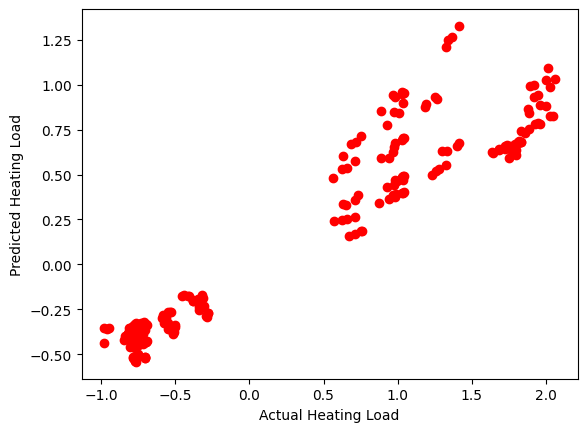

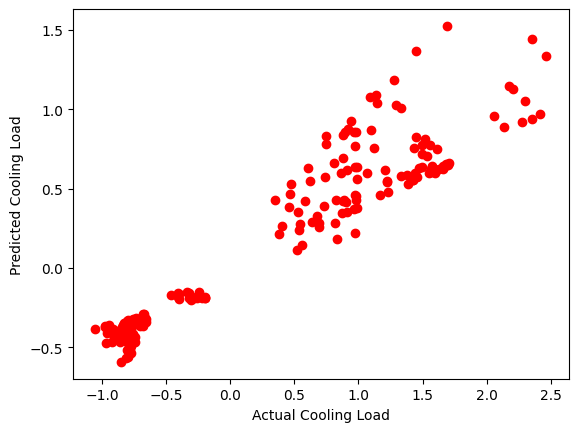

In [12]:
print(Y_pred.shape, var_Y_pred.shape)

print('Mean squared error for Y1:')
print(mean_squared_error(Y_test['Y1'].to_numpy(), Y_pred[:, 0]))
print('Mean squared error for Y2:')
print(mean_squared_error(Y_test['Y2'].to_numpy(), Y_pred[:, 1]))

plt.plot(Y_test['Y1'].to_numpy(), Y_pred[:, 0], 'ro')
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')
plt.show()

plt.plot(Y_test['Y2'].to_numpy(), Y_pred[:, 1], 'ro')
plt.xlabel('Actual Cooling Load')
plt.ylabel('Predicted Cooling Load')
plt.show()

#### Kernel Hyperparameter Tuning

In [13]:
def cross_validation(
    sigma: float,
    bandwidth: float,
    X: np.ndarray,
    Y: np.ndarray,
    k: int,
) -> float:
    """ Here we perform k-fold cross validation.

    Args:
        sigma (float)
        bandwidth (float)
        X (np.ndarray) : The training data.
        Y (np.ndarray) : The output for the training data.
        k (int) : The number of folds.

    Returns:
        float: The mean squared error.
    """
    N = X.shape[0]
    n = N // k
    mse = 0
    for i in range(k):
        X_train = np.concatenate((X[:i * n], X[(i + 1) * n:]))
        Y_train = np.concatenate((Y[:i * n], Y[(i + 1) * n:]))
        X_test = X[i * n:(i + 1) * n]
        Y_test = Y[i * n:(i + 1) * n]
        gpr = GaussianProcessRegression(sigma, bandwidth, X_train, Y_train)
        Y_pred, _ = gpr.predict(X_test)
        mse += mean_squared_error(Y_test, Y_pred)
    # END for
    return mse / k
# END def cross_validation

In [14]:
def grid_search(
    X: np.ndarray,
    Y: np.ndarray,
    k: int,
) -> tuple:
    """ Here we perform grid search to find the best hyperparameters.

    Args:
        X (np.ndarray) : The training data.
        Y (np.ndarray) : The output for the training data.
        k (int) : The number of folds.

    Returns:
        tuple: The best hyperparameters.
    """
    best_sigma, best_bandwidth = None, None
    best_mse = np.inf
    for sigma in np.arange(0.1, 1.1, 0.1):
        for bandwidth in np.arange(0.1, 1.1, 0.1):
            mse = cross_validation(sigma, bandwidth, X, Y, k)
            if mse < best_mse:
                best_mse = mse
                best_sigma = sigma
                best_bandwidth = bandwidth
            # END if
        # END for
    # END for
    return best_sigma, best_bandwidth
# END def grid_search

In [15]:
best_sigma, best_bandwidth = grid_search(
    X.to_numpy(), Y.to_numpy(), 5)

In [ ]:
print(best_sigma, best_bandwidth)